In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm  # For Vision Transformer models
import matplotlib.pyplot as plt
import time
import copy
import json
from tqdm import tqdm
import os

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.rea

PyTorch version: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Ti
Using device: cuda


In [2]:
# Set dataset paths
BASE_PATH = "/home/ubuntu/Desktop/AIML project/AlphaNum"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VALIDATION_PATH = os.path.join(BASE_PATH, "validation")
TEST_PATH = os.path.join(BASE_PATH, "test")
RESULTS_PATH = "/home/ubuntu/Desktop/AIML project/results/ViT"
# Create results folder
os.makedirs(RESULTS_PATH, exist_ok=True)

print(f"Train: {TRAIN_PATH}")
print(f"Validation: {VALIDATION_PATH}")
print(f"Test: {TEST_PATH}")
print(f"Results: {RESULTS_PATH}")


Train: /home/ubuntu/Desktop/AIML project/AlphaNum/train
Validation: /home/ubuntu/Desktop/AIML project/AlphaNum/validation
Test: /home/ubuntu/Desktop/AIML project/AlphaNum/test
Results: /home/ubuntu/Desktop/AIML project/results/ViT


In [3]:
# Image size
IMG_SIZE = 48

# Training transforms (with augmentation)
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Validation/Test transforms (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print("Training: With augmentation")
print("Validation/Test: No augmentation")


Image size: 48x48
Training: With augmentation
Validation/Test: No augmentation


In [4]:
# Load datasets
def load_dataset(path, transform):
    dataset = datasets.ImageFolder(root=path, transform=transform)
    # Sort classes for consistency
    classes = sorted(dataset.classes)
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    samples = [(p, class_to_idx[dataset.classes[k]]) for p, k in dataset.samples]
    dataset.classes = classes
    dataset.class_to_idx = class_to_idx
    dataset.samples = samples
    dataset.targets = [s[1] for s in samples]
    return dataset

print("Loading datasets...")
train_dataset = load_dataset(TRAIN_PATH, train_transforms)
validation_dataset = load_dataset(VALIDATION_PATH, val_test_transforms)
test_dataset = load_dataset(TEST_PATH, val_test_transforms)

num_classes = len(train_dataset.classes)

print(f"Classes: {num_classes}")
print(f"Training: {len(train_dataset)} samples")
print(f"Validation: {len(validation_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")


Loading datasets...
Classes: 53
Training: 53812 samples
Validation: 7486 samples
Test: 15362 samples


In [5]:
# Create Vision Transformer model
def create_vit_model(num_classes, img_size=48):
    model = timm.create_model(
        'vit_tiny_patch16_224',
        pretrained=False,
        num_classes=num_classes,
        img_size=img_size,
        in_chans=1
    )
    return model

model = create_vit_model(num_classes, img_size=IMG_SIZE)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Model: ViT-Tiny")
print(f"Parameters: {total_params:,}")
print(f"Device: {device}")


Model: ViT-Tiny
Parameters: 5,400,437
Device: cuda


# Vision Transformer (ViT) for AlphaNumeric Character Classification

This notebook implements a Vision Transformer model for classifying 24x24 grayscale images of alphanumeric characters (a-z, A-Z) and invalid characters (999).

## Features:
- ✅ Vision Transformer architecture adapted for small images
- ✅ Hyperparameter tuning with early stopping
- ✅ Learning rate scheduling
- ✅ Model checkpointing
- ✅ Comprehensive training visualization
- ✅ Overfitting prevention
- ✅ Batch prediction and analysis

In [6]:
# Create DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(validation_loader)}")
print(f"Test batches: {len(test_loader)}")


Batch size: 64
Training batches: 841
Validation batches: 117
Test batches: 241


## 7. Hyperparameter Configuration & Early Stopping

Configure hyperparameters and callbacks to prevent overfitting.

In [7]:
# Hyperparameters
MAX_EPOCHS = 150
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.01
EARLY_STOPPING_PATIENCE = 7
MIN_DELTA = 0.001

print(f"Max Epochs: {MAX_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Early stopping variables
best_val_loss = float('inf')
best_val_accuracy = 0.0
epochs_no_improve = 0
best_model_weights = None
early_stop = False

print("Setup complete!")


Max Epochs: 150
Learning Rate: 0.0001
Weight Decay: 0.01
Early Stopping Patience: 7
Setup complete!


/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 8. Training Loop with Early Stopping

Train the Vision Transformer model with comprehensive monitoring.

In [8]:
# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
learning_rates = []

print(f"Starting training for {MAX_EPOCHS} epochs...\n")

for epoch in range(MAX_EPOCHS):
    if early_stop:
        print(f"Early stopping at epoch {epoch}")
        break
    
    start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{MAX_EPOCHS} [Train]'):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(validation_loader, desc=f'Epoch {epoch+1}/{MAX_EPOCHS} [Val]'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(validation_dataset)
    epoch_val_acc = 100 * correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    # Learning rate scheduling
    scheduler.step(epoch_val_loss)
    
    # Early stopping
    if best_val_loss - epoch_val_loss > MIN_DELTA:
        best_val_loss = epoch_val_loss
        best_val_accuracy = epoch_val_acc
        epochs_no_improve = 0
        best_model_weights = copy.deepcopy(model.state_dict())
        status = " BEST " + f"{epoch_val_acc:.2f}%"
    else:
        epochs_no_improve += 1
        status = f"No improve ({epochs_no_improve}/{EARLY_STOPPING_PATIENCE})"
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            early_stop = True
    
    elapsed = time.time() - start_time
    print(f'Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f} Acc={epoch_train_acc:.2f}% | '
          f'Val Loss={epoch_val_loss:.4f} Acc={epoch_val_acc:.2f}% | {status} ({elapsed:.2f}s)')

# Restore best model
if best_model_weights:
    model.load_state_dict(best_model_weights)
    print(f"\nBest model restored: Val Loss={best_val_loss:.4f}, Val Acc={best_val_accuracy:.2f}%")


Starting training for 150 epochs...



Epoch 1/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 47.78it/s]


Epoch 1: Train Loss=3.0931 Acc=20.29% | Val Loss=2.6727 Acc=27.30% |  BEST 27.30% (33.86s)


Epoch 2/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 49.16it/s]


Epoch 2: Train Loss=1.7094 Acc=53.03% | Val Loss=1.2779 Acc=63.44% |  BEST 63.44% (32.96s)


Epoch 3/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 49.38it/s]


Epoch 3: Train Loss=1.0643 Acc=68.74% | Val Loss=1.0000 Acc=69.22% |  BEST 69.22% (32.63s)


Epoch 4/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 50.07it/s]


Epoch 4: Train Loss=0.8320 Acc=74.53% | Val Loss=0.7139 Acc=77.76% |  BEST 77.76% (32.46s)


Epoch 5/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 49.62it/s]


Epoch 5: Train Loss=0.7096 Acc=77.34% | Val Loss=0.7019 Acc=77.48% |  BEST 77.48% (32.67s)


Epoch 6/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 47.40it/s]


Epoch 6: Train Loss=0.6348 Acc=79.31% | Val Loss=0.5823 Acc=80.80% |  BEST 80.80% (33.07s)


Epoch 7/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 47.96it/s]


Epoch 7: Train Loss=0.5790 Acc=80.86% | Val Loss=0.5227 Acc=82.65% |  BEST 82.65% (33.84s)


Epoch 8/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.40it/s]


Epoch 8: Train Loss=0.5375 Acc=82.12% | Val Loss=0.5389 Acc=82.09% | No improve (1/7) (33.36s)


Epoch 9/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 49.12it/s]


Epoch 9: Train Loss=0.5068 Acc=82.65% | Val Loss=0.4649 Acc=84.02% |  BEST 84.02% (33.11s)


Epoch 10/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.66it/s]


Epoch 10: Train Loss=0.4786 Acc=83.66% | Val Loss=0.4711 Acc=83.80% | No improve (1/7) (33.24s)


Epoch 11/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 47.42it/s]


Epoch 11: Train Loss=0.4542 Acc=84.27% | Val Loss=0.4551 Acc=84.46% |  BEST 84.46% (33.39s)


Epoch 12/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.01it/s]


Epoch 12: Train Loss=0.4344 Acc=84.80% | Val Loss=0.4217 Acc=85.12% |  BEST 85.12% (33.53s)


Epoch 13/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.36it/s]


Epoch 13: Train Loss=0.4110 Acc=85.59% | Val Loss=0.4017 Acc=85.57% |  BEST 85.57% (33.51s)


Epoch 14/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 47.82it/s]


Epoch 14: Train Loss=0.4085 Acc=85.56% | Val Loss=0.4097 Acc=85.49% | No improve (1/7) (33.55s)


Epoch 15/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.16it/s]


Epoch 15: Train Loss=0.3799 Acc=86.36% | Val Loss=0.3814 Acc=85.96% |  BEST 85.96% (33.69s)


Epoch 16/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.59it/s]


Epoch 16: Train Loss=0.3704 Acc=86.78% | Val Loss=0.3800 Acc=86.60% |  BEST 86.60% (33.65s)


Epoch 17/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 47.84it/s]



Epoch 17: Train Loss=0.3576 Acc=86.94% | Val Loss=0.3727 Acc=86.84% |  BEST 86.84% (33.47s)


Epoch 18/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.96it/s]


Epoch 18: Train Loss=0.3498 Acc=87.29% | Val Loss=0.3874 Acc=86.31% | No improve (1/7) (33.55s)


Epoch 19/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 45.82it/s]


Epoch 19: Train Loss=0.3392 Acc=87.58% | Val Loss=0.3468 Acc=87.54% |  BEST 87.54% (34.18s)


Epoch 20/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 45.65it/s]


Epoch 20: Train Loss=0.3283 Acc=87.87% | Val Loss=0.3612 Acc=87.08% | No improve (1/7) (34.47s)


Epoch 21/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.69it/s]


Epoch 21: Train Loss=0.3225 Acc=88.09% | Val Loss=0.3594 Acc=87.04% | No improve (2/7) (34.01s)


Epoch 22/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 47.59it/s]


Epoch 22: Train Loss=0.3153 Acc=88.36% | Val Loss=0.3497 Acc=87.34% | No improve (3/7) (33.97s)


Epoch 23/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 46.45it/s]


Epoch 23: Train Loss=0.3078 Acc=88.47% | Val Loss=0.3396 Acc=87.96% |  BEST 87.96% (34.41s)


Epoch 24/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 47.43it/s]


Epoch 24: Train Loss=0.2967 Acc=88.88% | Val Loss=0.3320 Acc=88.26% |  BEST 88.26% (34.24s)


Epoch 25/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.30it/s]


Epoch 25: Train Loss=0.2894 Acc=89.18% | Val Loss=0.3463 Acc=87.67% | No improve (1/7) (33.65s)


Epoch 26/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.27it/s]


Epoch 26: Train Loss=0.2855 Acc=89.18% | Val Loss=0.3340 Acc=87.52% | No improve (2/7) (33.24s)


Epoch 27/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 49.17it/s]


Epoch 27: Train Loss=0.2802 Acc=89.29% | Val Loss=0.3125 Acc=88.65% |  BEST 88.65% (33.41s)


Epoch 28/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.88it/s]


Epoch 28: Train Loss=0.2697 Acc=89.69% | Val Loss=0.3298 Acc=88.23% | No improve (1/7) (32.95s)


Epoch 29/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 47.53it/s]


Epoch 29: Train Loss=0.2667 Acc=89.74% | Val Loss=0.3215 Acc=87.99% | No improve (2/7) (33.10s)


Epoch 30/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.95it/s]


Epoch 30: Train Loss=0.2627 Acc=89.88% | Val Loss=0.3136 Acc=88.47% | No improve (3/7) (32.84s)


Epoch 31/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.71it/s]


Epoch 31: Train Loss=0.2578 Acc=90.13% | Val Loss=0.3106 Acc=88.38% |  BEST 88.38% (32.74s)


Epoch 32/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.24it/s]


Epoch 32: Train Loss=0.2513 Acc=90.34% | Val Loss=0.3041 Acc=88.75% |  BEST 88.75% (33.03s)


Epoch 33/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.02it/s]


Epoch 33: Train Loss=0.2441 Acc=90.41% | Val Loss=0.3156 Acc=88.58% | No improve (1/7) (33.24s)


Epoch 34/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.72it/s]


Epoch 34: Train Loss=0.2415 Acc=90.51% | Val Loss=0.3207 Acc=88.35% | No improve (2/7) (34.14s)


Epoch 35/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 49.48it/s]


Epoch 35: Train Loss=0.2385 Acc=90.66% | Val Loss=0.3138 Acc=88.65% | No improve (3/7) (33.02s)


Epoch 36/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.62it/s]


Epoch 36: Train Loss=0.2340 Acc=90.81% | Val Loss=0.3075 Acc=88.46% | No improve (4/7) (33.02s)


Epoch 37/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.12it/s]


Epoch 37: Train Loss=0.1934 Acc=92.10% | Val Loss=0.2732 Acc=89.97% |  BEST 89.97% (33.50s)


Epoch 38/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 49.70it/s]


Epoch 38: Train Loss=0.1850 Acc=92.56% | Val Loss=0.2802 Acc=89.98% | No improve (1/7) (32.84s)


Epoch 39/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 45.46it/s]


Epoch 39: Train Loss=0.1824 Acc=92.65% | Val Loss=0.2811 Acc=89.69% | No improve (2/7) (32.48s)


Epoch 40/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 49.30it/s]


Epoch 40: Train Loss=0.1766 Acc=92.77% | Val Loss=0.2764 Acc=90.03% | No improve (3/7) (32.73s)


Epoch 41/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 52.07it/s]


Epoch 41: Train Loss=0.1763 Acc=92.85% | Val Loss=0.2873 Acc=89.46% | No improve (4/7) (31.57s)


Epoch 42/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 52.08it/s]


Epoch 42: Train Loss=0.1556 Acc=93.64% | Val Loss=0.2701 Acc=90.22% |  BEST 90.22% (31.63s)


Epoch 43/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 50.49it/s]


Epoch 43: Train Loss=0.1514 Acc=93.83% | Val Loss=0.2696 Acc=90.07% | No improve (1/7) (31.88s)


Epoch 44/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 45.81it/s]


Epoch 44: Train Loss=0.1486 Acc=93.90% | Val Loss=0.2658 Acc=90.15% |  BEST 90.15% (32.31s)


Epoch 45/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.57it/s]


Epoch 45: Train Loss=0.1471 Acc=93.94% | Val Loss=0.2762 Acc=89.77% | No improve (1/7) (33.31s)


Epoch 46/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 47.07it/s]


Epoch 46: Train Loss=0.1464 Acc=94.01% | Val Loss=0.2681 Acc=90.41% | No improve (2/7) (33.44s)


Epoch 47/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 49.29it/s]


Epoch 47: Train Loss=0.1423 Acc=94.09% | Val Loss=0.2727 Acc=90.10% | No improve (3/7) (33.03s)


Epoch 48/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.26it/s]


Epoch 48: Train Loss=0.1426 Acc=94.09% | Val Loss=0.2734 Acc=90.46% | No improve (4/7) (33.07s)


Epoch 49/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.84it/s]


Epoch 49: Train Loss=0.1327 Acc=94.56% | Val Loss=0.2622 Acc=90.44% |  BEST 90.44% (32.99s)


Epoch 50/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 50.04it/s]


Epoch 50: Train Loss=0.1297 Acc=94.76% | Val Loss=0.2620 Acc=90.64% | No improve (1/7) (32.95s)


Epoch 51/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.12it/s]


Epoch 51: Train Loss=0.1280 Acc=94.63% | Val Loss=0.2647 Acc=90.57% | No improve (2/7) (33.21s)


Epoch 52/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.90it/s]


Epoch 52: Train Loss=0.1257 Acc=94.79% | Val Loss=0.2696 Acc=90.45% | No improve (3/7) (32.86s)


Epoch 53/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 49.22it/s]


Epoch 53: Train Loss=0.1260 Acc=94.68% | Val Loss=0.2713 Acc=90.25% | No improve (4/7) (33.13s)


Epoch 54/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.76it/s]


Epoch 54: Train Loss=0.1242 Acc=94.90% | Val Loss=0.2656 Acc=90.42% | No improve (5/7) (33.06s)


Epoch 55/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.23it/s]


Epoch 55: Train Loss=0.1185 Acc=95.17% | Val Loss=0.2672 Acc=90.76% | No improve (6/7) (33.04s)


Epoch 56/150 [Val]: 100%|██████████| 117/117 [00:02<00:00, 48.80it/s]

Epoch 56: Train Loss=0.1180 Acc=95.17% | Val Loss=0.2657 Acc=90.72% | No improve (7/7) (33.11s)
Early stopping at epoch 56

Best model restored: Val Loss=0.2622, Val Acc=90.44%


## 9. Training Visualization

Comprehensive visualization of training metrics to analyze model performance.

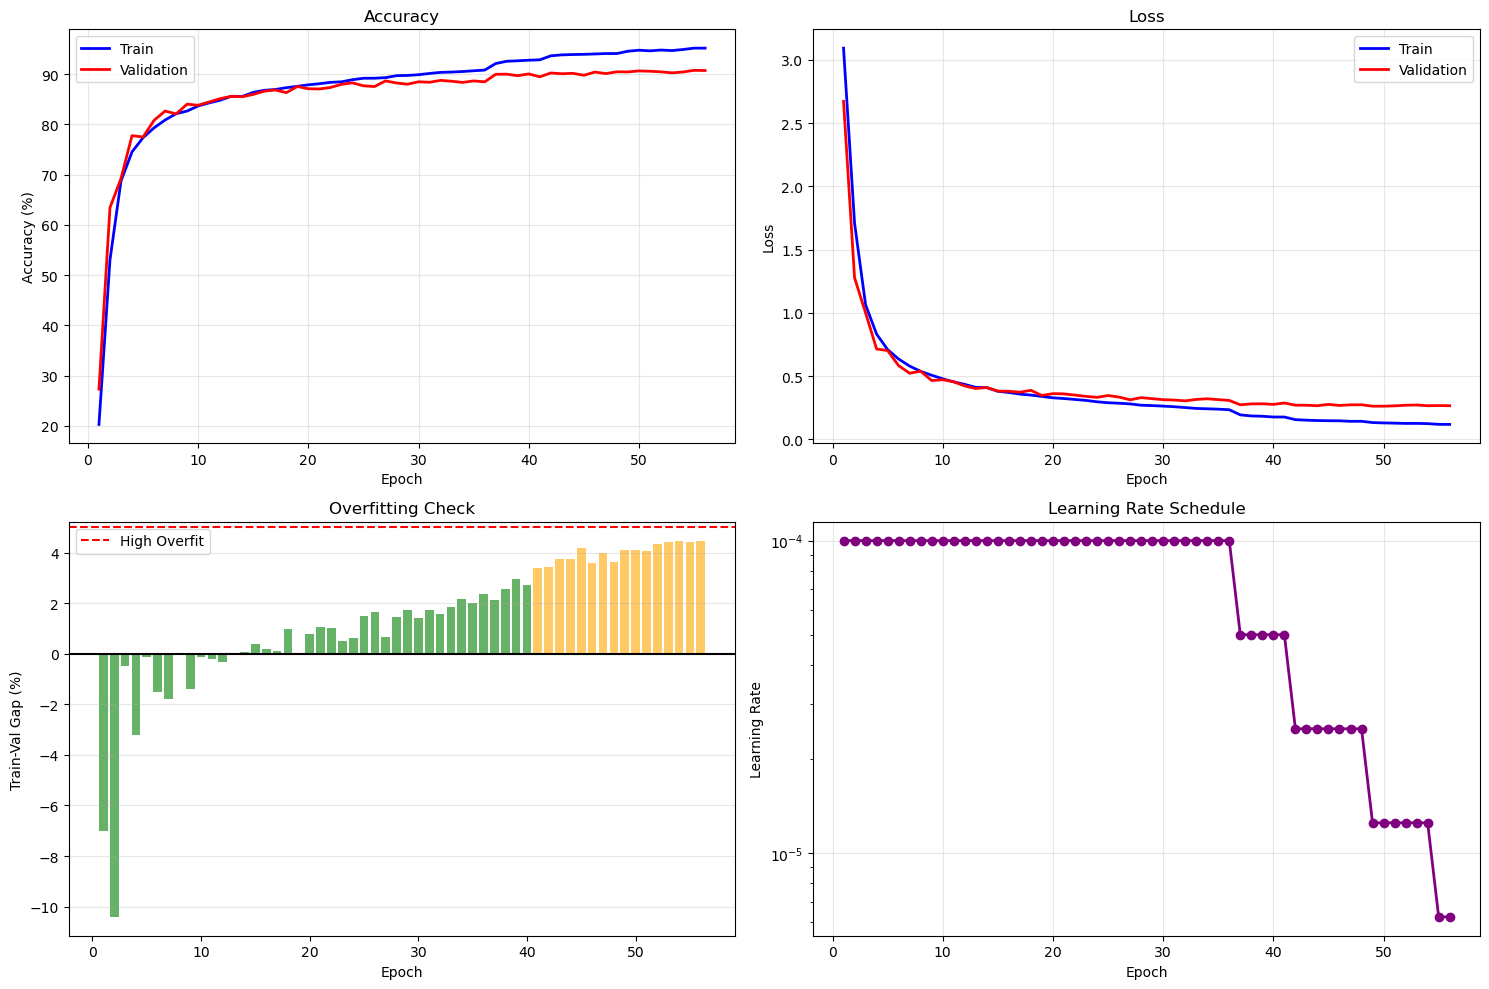


Best Train Accuracy: 95.17%
Best Val Accuracy: 90.76%


In [9]:
# Plot training results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
epochs = range(1, len(train_accuracies) + 1)

# Accuracy plot
axes[0, 0].plot(epochs, train_accuracies, 'b-', label='Train', linewidth=2)
axes[0, 0].plot(epochs, val_accuracies, 'r-', label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_title('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss plot
axes[0, 1].plot(epochs, train_losses, 'b-', label='Train', linewidth=2)
axes[0, 1].plot(epochs, val_losses, 'r-', label='Validation', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Train-Val gap
gap = [train_accuracies[i] - val_accuracies[i] for i in range(len(train_accuracies))]
colors = ['red' if g > 5 else 'green' if g < 3 else 'orange' for g in gap]
axes[1, 0].bar(epochs, gap, color=colors, alpha=0.6)
axes[1, 0].axhline(y=5, color='red', linestyle='--', label='High Overfit')
axes[1, 0].axhline(y=0, color='black', linestyle='-')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Train-Val Gap (%)')
axes[1, 0].set_title('Overfitting Check')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Learning rate
axes[1, 1].plot(epochs, learning_rates, 'purple', marker='o', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Train Accuracy: {max(train_accuracies):.2f}%")
print(f"Best Val Accuracy: {max(val_accuracies):.2f}%")


## 10. Model Evaluation on Test Set

In [10]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")
print(f"Correct: {correct}/{total}")


Testing: 100%|██████████| 241/241 [00:04<00:00, 48.52it/s]


Test Accuracy: 90.91%
Correct: 13966/15362


## 10.1 Detailed Performance Metrics

Calculate precision, recall, F1-score, and confusion matrix for comprehensive model evaluation.

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np

# Collect all predictions and true labels from test set
print("Generating predictions for detailed metrics...")
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Collecting predictions'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate metrics
precision_macro = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

precision_weighted = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
recall_weighted = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
f1_weighted = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

# Display results
print("\n" + "=" * 80)
print("DETAILED PERFORMANCE METRICS - VISION TRANSFORMER")
print("=" * 80)
print("\nMACRO AVERAGES (Equal weight for each class):")
print(f"  Precision (Macro): {precision_macro:.4f} ({precision_macro*100:.2f}%)")
print(f"  Recall (Macro):    {recall_macro:.4f} ({recall_macro*100:.2f}%)")
print(f"  F1-Score (Macro):  {f1_macro:.4f} ({f1_macro*100:.2f}%)")

print("\nWEIGHTED AVERAGES (Weighted by class frequency):")
print(f"  Precision (Weighted): {precision_weighted:.4f} ({precision_weighted*100:.2f}%)")
print(f"  Recall (Weighted):    {recall_weighted:.4f} ({recall_weighted*100:.2f}%)")
print(f"  F1-Score (Weighted):  {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")

# Get class names from dataset
class_names = train_dataset.classes

# Get class names for the report
unique_labels = np.unique(all_labels)
display_names = []
for label_idx in unique_labels:
    class_name = class_names[label_idx]
    if class_name == '999':
        display_names.append('NULL')
    else:
        display_names.append(chr(int(class_name)))

print("\n" + "=" * 80)
print("CLASSIFICATION REPORT (Per-class metrics)")
print("=" * 80)
print(classification_report(all_labels, all_predictions, 
                           target_names=display_names, zero_division=0))

# Save metrics
import pandas as pd
metrics_data = {
    'Metric': ['Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)', 
               'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
    'Score': [precision_macro, recall_macro, f1_macro, 
              precision_weighted, recall_weighted, f1_weighted],
    'Percentage': [f"{precision_macro*100:.2f}%", f"{recall_macro*100:.2f}%", 
                   f"{f1_macro*100:.2f}%", f"{precision_weighted*100:.2f}%", 
                   f"{recall_weighted*100:.2f}%", f"{f1_weighted*100:.2f}%"]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_csv_path = os.path.join(RESULTS_PATH, 'precision_recall_f1_scores.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n✓ Metrics saved to: {metrics_csv_path}")

Generating predictions for detailed metrics...



DETAILED PERFORMANCE METRICS - VISION TRANSFORMER

MACRO AVERAGES (Equal weight for each class):
  Precision (Macro): 0.8888 (88.88%)
  Recall (Macro):    0.8855 (88.55%)
  F1-Score (Macro):  0.8862 (88.62%)

WEIGHTED AVERAGES (Weighted by class frequency):
  Precision (Weighted): 0.9098 (90.98%)
  Recall (Weighted):    0.9091 (90.91%)
  F1-Score (Weighted):  0.9089 (90.89%)

CLASSIFICATION REPORT (Per-class metrics)
              precision    recall  f1-score   support

           d       0.98      0.98      0.98       214
           e       0.97      0.96      0.96       592
           f       0.87      0.92      0.89       121
           g       0.90      0.88      0.89       152
           h       0.95      0.95      0.95       198
           i       0.94      0.93      0.93       407
           j       0.95      0.92      0.93        85
           k       0.78      0.69      0.73       111
           l       0.74      0.91      0.81       283
           m       0.87      0.89    

### Visualize Precision, Recall, and F1-Score

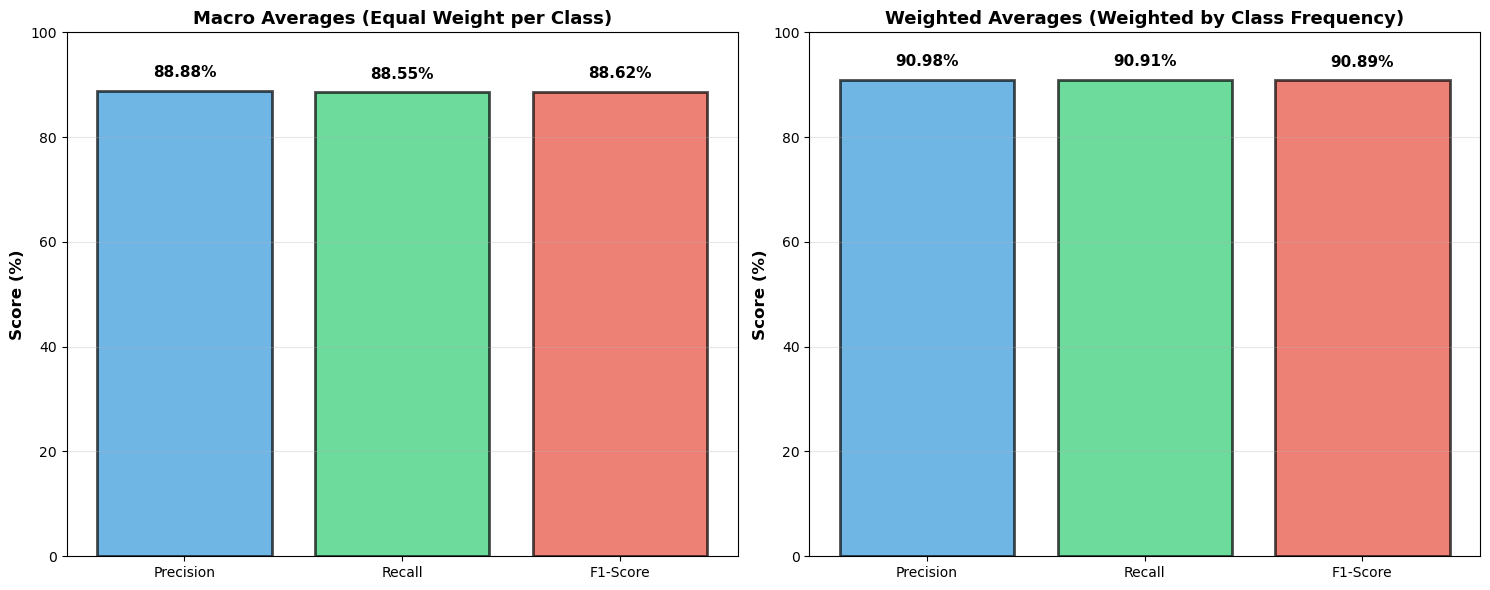

✓ Metrics chart saved to: /home/ubuntu/Desktop/AIML project/results/ViT/precision_recall_f1_scores_chart.png


In [13]:
import matplotlib.pyplot as plt

# Create visualization of metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Macro Averages
metrics_names = ['Precision', 'Recall', 'F1-Score']
scores_macro = [precision_macro * 100, recall_macro * 100, f1_macro * 100]
colors_metrics = ['#3498db', '#2ecc71', '#e74c3c']

ax1 = axes[0]
bars1 = ax1.bar(metrics_names, scores_macro, color=colors_metrics, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax1.set_title('Macro Averages (Equal Weight per Class)', fontsize=13, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(axis='y', alpha=0.3)

for bar, score in zip(bars1, scores_macro):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{score:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 2: Weighted Averages
scores_weighted = [precision_weighted * 100, recall_weighted * 100, f1_weighted * 100]
ax2 = axes[1]
bars2 = ax2.bar(metrics_names, scores_weighted, color=colors_metrics, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax2.set_title('Weighted Averages (Weighted by Class Frequency)', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 100])
ax2.grid(axis='y', alpha=0.3)

for bar, score in zip(bars2, scores_weighted):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{score:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
metrics_chart_path = os.path.join(RESULTS_PATH, 'precision_recall_f1_scores_chart.png')
plt.savefig(metrics_chart_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Metrics chart saved to: {metrics_chart_path}")

### Confusion Matrix

Visualize the confusion matrix to identify which characters are most commonly confused.

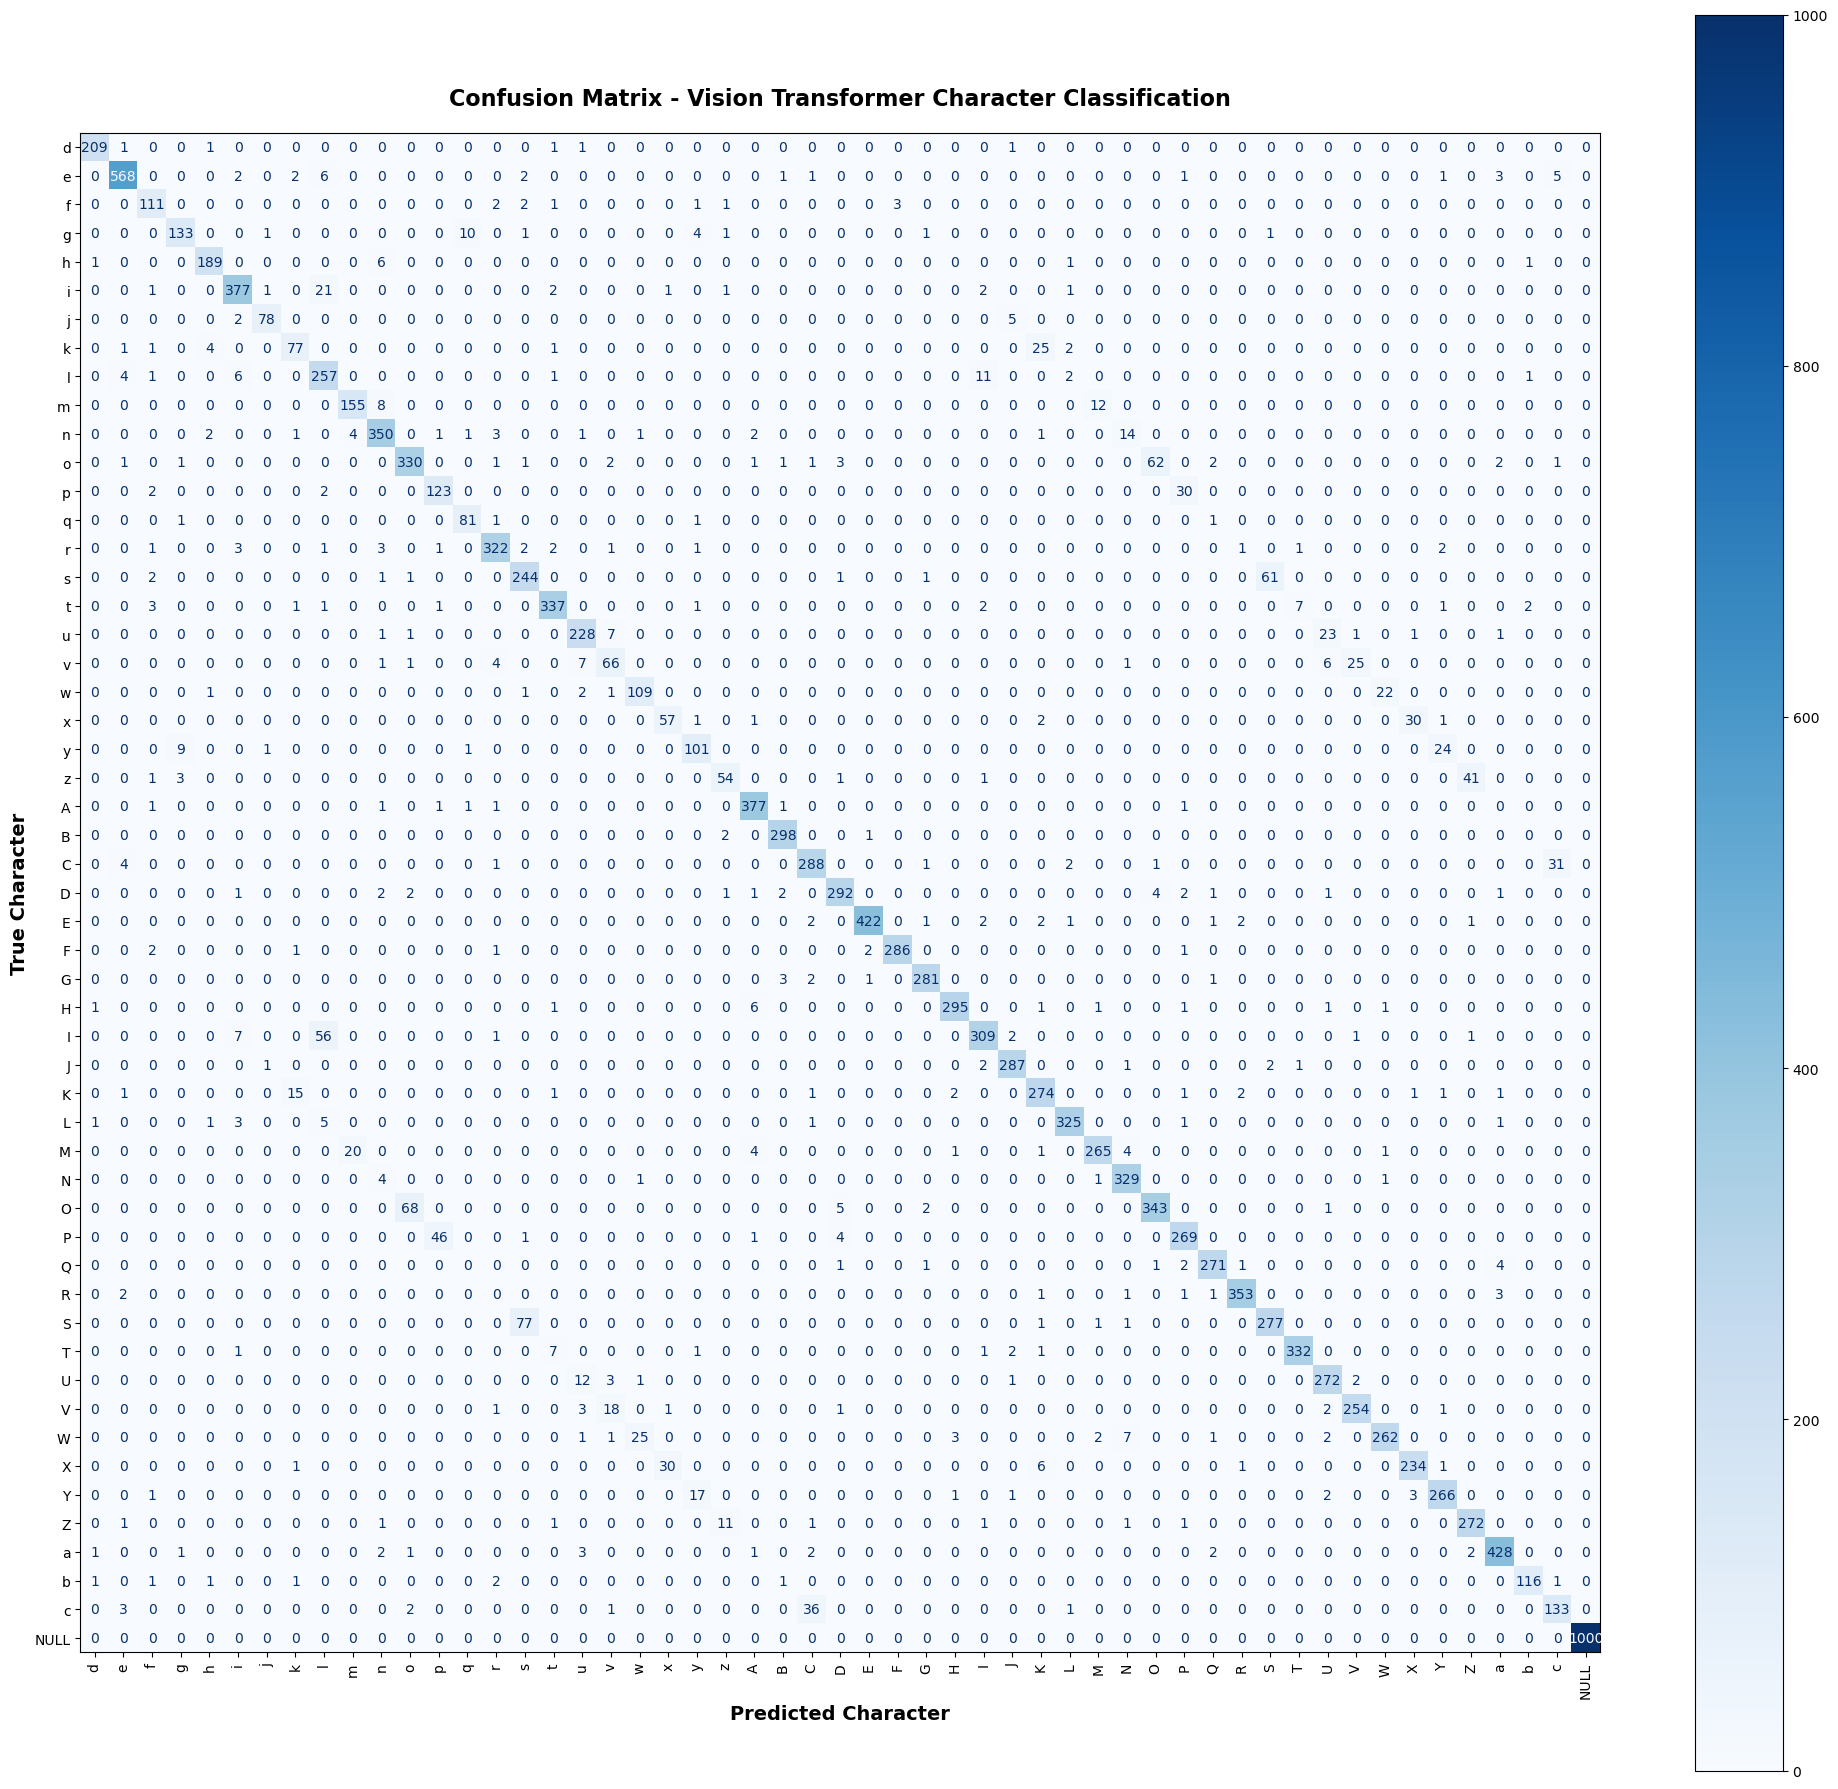

✓ Confusion matrix saved to: /home/ubuntu/Desktop/AIML project/results/ViT/confusion_matrix.png

MOST CONFUSED CHARACTER PAIRS

True     Predicted  Count   
------------------------------
S        s          77      
O        o          68      
o        O          62      
s        S          61      
I        l          56      
P        p          46      
z        Z          41      
c        C          36      
C        c          31      
p        P          30      


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Create figure for confusion matrix
fig, ax = plt.subplots(figsize=(20, 18))

# Display confusion matrix with character labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical', values_format='d')

ax.set_title('Confusion Matrix - Vision Transformer Character Classification', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Predicted Character', fontsize=14, fontweight='bold')
ax.set_ylabel('True Character', fontsize=14, fontweight='bold')

plt.tight_layout()

# Save confusion matrix
cm_path = os.path.join(RESULTS_PATH, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved to: {cm_path}")

# Analyze most confused pairs
print("\n" + "=" * 80)
print("MOST CONFUSED CHARACTER PAIRS")
print("=" * 80)

# Find top 10 misclassifications (excluding diagonal)
misclassifications = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i][j] > 0:
            misclassifications.append((display_names[i], display_names[j], cm[i][j]))

# Sort by count and get top 10
misclassifications.sort(key=lambda x: x[2], reverse=True)
top_10 = misclassifications[:10] if len(misclassifications) >= 10 else misclassifications

if top_10:
    print(f"\n{'True':<8} {'Predicted':<10} {'Count':<8}")
    print("-" * 30)
    for true_char, pred_char, count in top_10:
        print(f"{true_char:<8} {pred_char:<10} {count:<8}")
else:
    print("\n✓ No misclassifications found! Perfect accuracy!")

print("=" * 80)

## 11. Save Model and Training History

In [15]:
# Save model and results
model_path = os.path.join(RESULTS_PATH, 'vit_model.pth')
torch.save(model.state_dict(), model_path)
print(f"Model saved: {model_path}")

# Save training history
history = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'learning_rates': learning_rates,
    'test_accuracy': test_accuracy,
    'best_val_accuracy': best_val_accuracy
}

history_path = os.path.join(RESULTS_PATH, 'history.json')
with open(history_path, 'w') as f:
    json.dump(history, f, indent=4)
print(f"History saved: {history_path}")

# Save class names
classes_path = os.path.join(RESULTS_PATH, 'classes.txt')
with open(classes_path, 'w') as f:
    f.write('\n'.join(train_dataset.classes))
print(f"Classes saved: {classes_path}")


Model saved: /home/ubuntu/Desktop/AIML project/results/ViT/vit_model.pth
History saved: /home/ubuntu/Desktop/AIML project/results/ViT/history.json
Classes saved: /home/ubuntu/Desktop/AIML project/results/ViT/classes.txt


## 12. Load Saved Model and Make Predictions

In [16]:
# Load saved model
loaded_model = create_vit_model(num_classes, img_size=IMG_SIZE)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model = loaded_model.to(device)
loaded_model.eval()

# Load class names
with open(classes_path, 'r') as f:
    class_names = f.read().strip().split('\n')

print(f"Model loaded from: {model_path}")
print(f"Classes: {len(class_names)}")


Model loaded from: /home/ubuntu/Desktop/AIML project/results/ViT/vit_model.pth
Classes: 53


/tmp/ipykernel_39222/20041636.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


## 13. Batch Prediction with Visualization

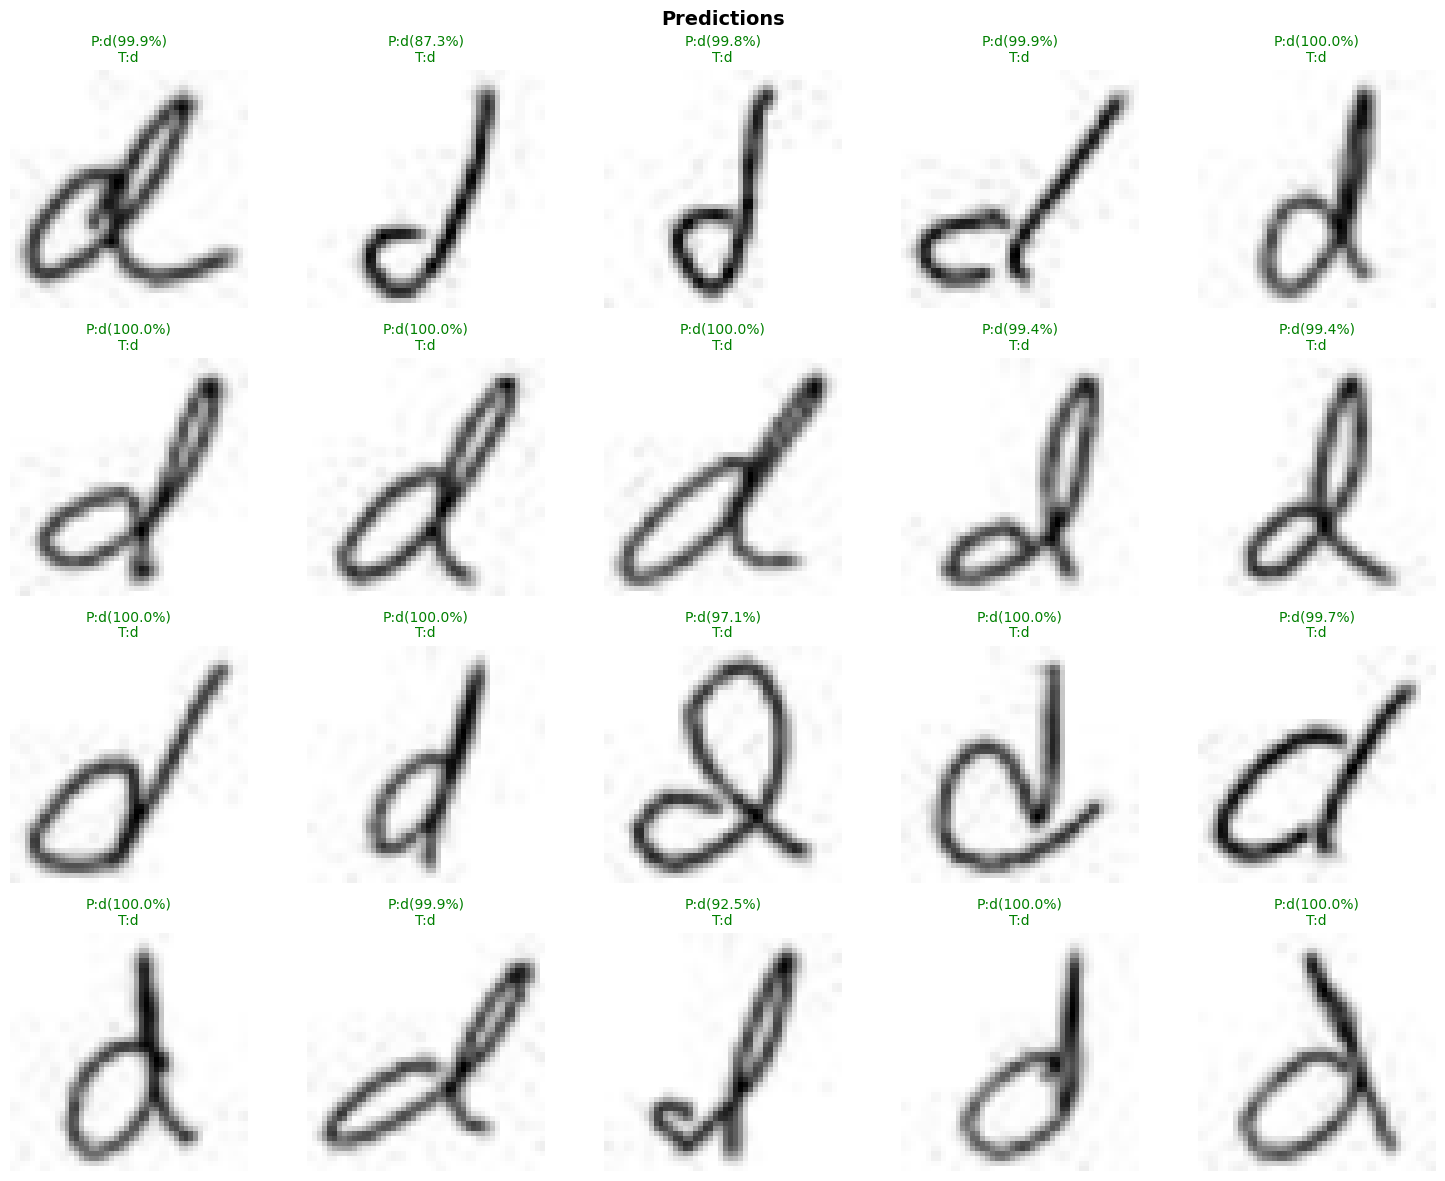

Batch Accuracy: 96.88%


In [ ]:
# Predict and visualize batch
import torch.nn.functional as F

def predict_batch(model, data_loader, num_images=20):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        confs, preds = torch.max(probs, 1)
    
    # Visualize
    num_show = min(num_images, len(images))
    fig, axes = plt.subplots((num_show + 4) // 5, 5, figsize=(15, 3 * ((num_show + 4) // 5)))
    axes = axes.flatten() if num_show > 5 else [axes]
    
    for i in range(num_show):
        img = images[i].cpu().numpy().squeeze()
        pred_class = class_names[preds[i].item()]
        true_class = class_names[labels[i].item()]
        conf = confs[i].item() * 100
        
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        
        pred_char = chr(int(pred_class)) if pred_class != '999' else 'NULL'
        true_char = chr(int(true_class)) if true_class != '999' else 'NULL'
        color = 'green' if pred_class == true_class else 'red'
        
        axes[i].set_title(f"P:{pred_char}({conf:.1f}%)\nT:{true_char}", color=color, fontsize=10)
    
    plt.suptitle("Predictions", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    correct = (preds == labels).sum().item()
    print(f"Batch Accuracy: {100*correct/len(labels):.2f}%")

predict_batch(loaded_model, test_loader, num_images=20)


## 13.1 Single Image Prediction from File Path

Load and predict a single image from any file path on your system.

🔍 Loading image from: /home/ubuntu/Pictures/asaad.png



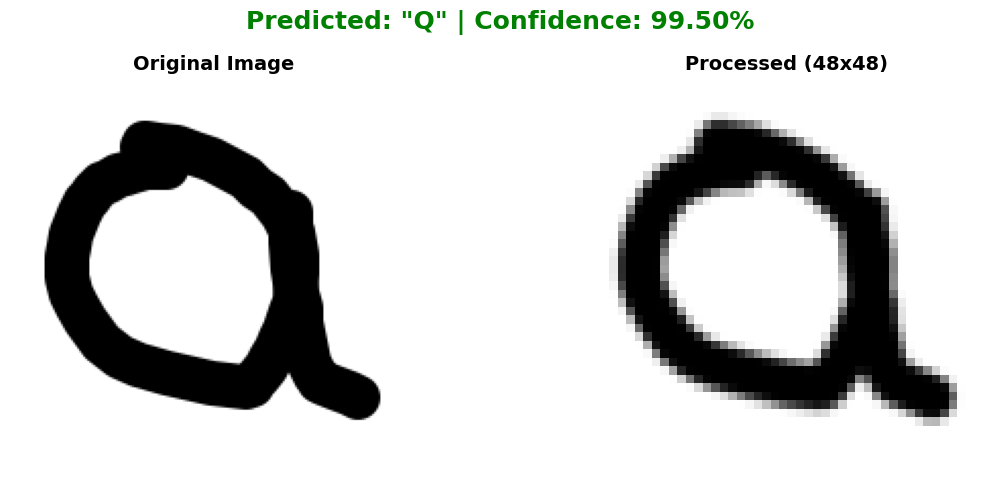


                     🔮 PREDICTION RESULTS
📁 Image Path:           /home/ubuntu/Pictures/asaad.png
🔤 Predicted Character:  'Q'
🏷️  ASCII Code:            81
📊 Confidence:           99.50%
📈 Confidence Bar:       [███████████████████░]
🎯 Confidence Level:     ✅ High

✅ Prediction complete! The model predicts: 'Q' with 99.5% confidence


In [17]:
from PIL import Image
import torch.nn.functional as F
import os

def predict_single_image(model, image_path, transform, class_names, device):
    """
    Predict a single image from file path.
    
    Args:
        model: Trained model
        image_path: Path to image file
        transform: Image transformation pipeline
        class_names: List of class names
        device: Computation device (cuda/cpu)
    
    Returns:
        predicted_class, confidence, predicted_character
    """
    # Check if file exists
    if not os.path.exists(image_path):
        print(f"❌ Error: File not found at '{image_path}'")
        print("Please check the path and try again.")
        return None, None, None
    
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        original_image = image.copy()
        
        # Apply transforms
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        # Make prediction
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            probs = F.softmax(output, dim=1)
            confidence, predicted_idx = torch.max(probs, 1)
        
        # Get results
        pred_class = class_names[predicted_idx.item()]
        conf_percent = confidence.item() * 100
        pred_char = chr(int(pred_class)) if pred_class != '999' else 'NULL/Invalid'
        
        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original image
        axes[0].imshow(original_image, cmap='gray')
        axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        # Processed image
        processed_img = input_tensor.cpu().squeeze().numpy()
        axes[1].imshow(processed_img, cmap='gray')
        axes[1].set_title(f'Processed (48x48)', fontsize=14, fontweight='bold')
        axes[1].axis('off')
        
        # Add prediction text with large, clear formatting
        confidence_color = 'green' if conf_percent > 80 else 'orange' if conf_percent > 60 else 'red'
        fig.suptitle(f'Predicted: "{pred_char}" | Confidence: {conf_percent:.2f}%', 
                     fontsize=18, fontweight='bold', color=confidence_color)
        plt.tight_layout()
        plt.show()
        
        # Print detailed results
        print("\n" + "="*70)
        print("                     🔮 PREDICTION RESULTS")
        print("="*70)
        print(f"📁 Image Path:           {image_path}")
        print(f"🔤 Predicted Character:  '{pred_char}'")
        print(f"🏷️  ASCII Code:            {pred_class}")
        print(f"📊 Confidence:           {conf_percent:.2f}%")
        confidence_bar = "█" * int(conf_percent // 5) + "░" * (20 - int(conf_percent // 5))
        print(f"📈 Confidence Bar:       [{confidence_bar}]")
        print(f"🎯 Confidence Level:     {'✅ High' if conf_percent > 90 else '⚠️ Medium' if conf_percent > 70 else '❌ Low'}")
        print("="*70 + "\n")
        
        return pred_class, conf_percent, pred_char
        
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Make sure the file is a valid image format (PNG, JPG, JPEG, etc.)")
        return None, None, None


# ============================================================================
# 🎯 CUSTOM IMAGE PATH - CHANGE THIS TO YOUR IMAGE FILE
# ============================================================================
# Examples:
#   - Linux:   '/home/username/Pictures/my_image.png'
#   - Windows: 'C:/Users/username/Pictures/my_image.png'
#   - Test:    '/media/ubuntu/NVME/AIML project/AlphaNum2/test/65/image_001.jpg'

IMAGE_PATH = '/home/ubuntu/Pictures/asaad.png'  # 👈 CHANGE THIS PATH

# ============================================================================

print(f"🔍 Loading image from: {IMAGE_PATH}\n")
predicted_class, confidence, predicted_char = predict_single_image(
    model=loaded_model,
    image_path=IMAGE_PATH,
    transform=val_test_transforms,
    class_names=class_names,
    device=device
)

if predicted_char:
    print(f"✅ Prediction complete! The model predicts: '{predicted_char}' with {confidence:.1f}% confidence")

## 14. Analyze Misclassified Images

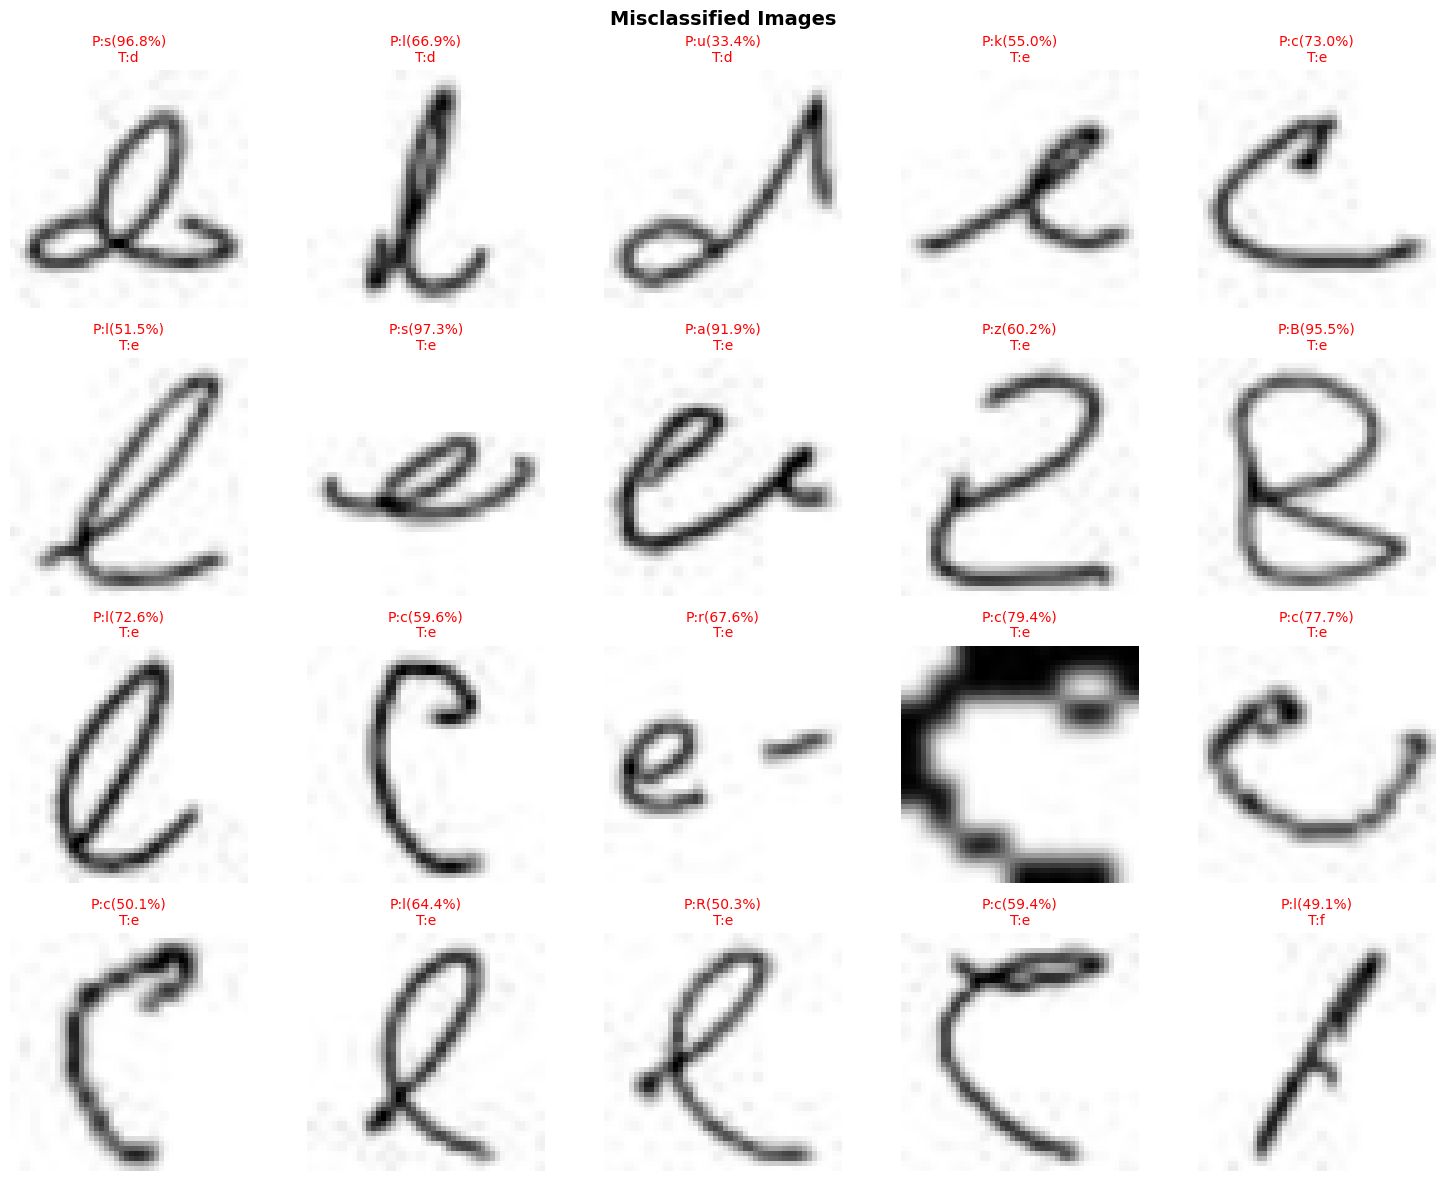

Misclassified: 23


In [ ]:
# Find misclassified images
loaded_model.eval()
misclassified = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)
        probs = F.softmax(outputs, dim=1)
        confs, preds = torch.max(probs, 1)
        
        # Find incorrect predictions
        wrong = preds != labels
        if wrong.any():
            for i in range(len(images)):
                if wrong[i]:
                    misclassified.append({
                        'image': images[i].cpu(),
                        'pred': preds[i].cpu(),
                        'true': labels[i].cpu(),
                        'conf': confs[i].cpu()
                    })
        
        if len(misclassified) >= 20:
            break

# Visualize misclassified
if misclassified:
    num_show = min(20, len(misclassified))
    fig, axes = plt.subplots((num_show + 4) // 5, 5, figsize=(15, 3 * ((num_show + 4) // 5)))
    axes = axes.flatten() if num_show > 5 else [axes]
    
    for i in range(num_show):
        img = misclassified[i]['image'].numpy().squeeze()
        pred = class_names[misclassified[i]['pred'].item()]
        true = class_names[misclassified[i]['true'].item()]
        conf = misclassified[i]['conf'].item() * 100
        
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        
        pred_char = chr(int(pred)) if pred != '999' else 'NULL'
        true_char = chr(int(true)) if true != '999' else 'NULL'
        
        axes[i].set_title(f"P:{pred_char}({conf:.1f}%)\nT:{true_char}", color='red', fontsize=10)
    
    plt.suptitle("Misclassified Images", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"Misclassified: {len(misclassified)}")
else:
    print("No misclassifications!")


## 15. Summary

### ✅ Completed Tasks:

1. **Vision Transformer Implementation** - ViT-Tiny adapted for 48x48 grayscale images
2. **Hyperparameter Tuning** - Configured learning rate, weight decay, and training parameters
3. **Early Stopping** - Prevents overfitting by stopping when validation loss plateaus
4. **Learning Rate Scheduling** - ReduceLROnPlateau for adaptive learning
5. **Comprehensive Visualization** - 4-panel training analysis
6. **Model Saving** - State dict, full model, and training history saved
7. **Batch Prediction** - Visualize predictions with confidence scores
8. **Misclassification Analysis** - Identify and visualize problem cases

### 📊 Key Features:

- **Automatic overfitting detection** with color-coded train-val gap visualization
- **Early stopping** saves best model weights and restores them after training
- **Learning rate reduction** when validation loss plateaus
- **Complete model persistence** - Easy to load and use for predictions
- **Comprehensive metrics tracking** - Loss, accuracy, and learning rate history

### 🚀 Next Steps:

1. Fine-tune hyperparameters (learning rate, batch size, image size)
2. Try different ViT architectures (vit_small, vit_base)
3. Experiment with pretrained weights
4. Add more data augmentation techniques
5. Implement cross-validation for robust evaluation

**Model saved to:** `{RESULTS_PATH}`